# Using precomputed boxplots

In [10]:
import pandas as pd
import numpy as np

from plotnine import (
    ggplot,
    aes,
    geom_boxplot
)
from plotnine.data import pageviews

import warnings
warnings.filterwarnings('ignore')

Plotting a boxplot when a dataset fits in memory is simple as shown below:

In [11]:
pageviews['hour'] = pageviews.date_hour.dt.hour
display(f'Dataset contains {pageviews.shape[0]} rows')
pageviews.head()

'Dataset contains 348 rows'

,date_hour,pageviews,hour
0,2013-02-11 21:00:00,8860.982383,21
1,2013-02-11 22:00:00,8637.474753,22
2,2013-02-11 23:00:00,9020.593099,23
3,2013-02-12 00:00:00,8437.500380,0
4,2013-02-12 01:00:00,9157.399672,1


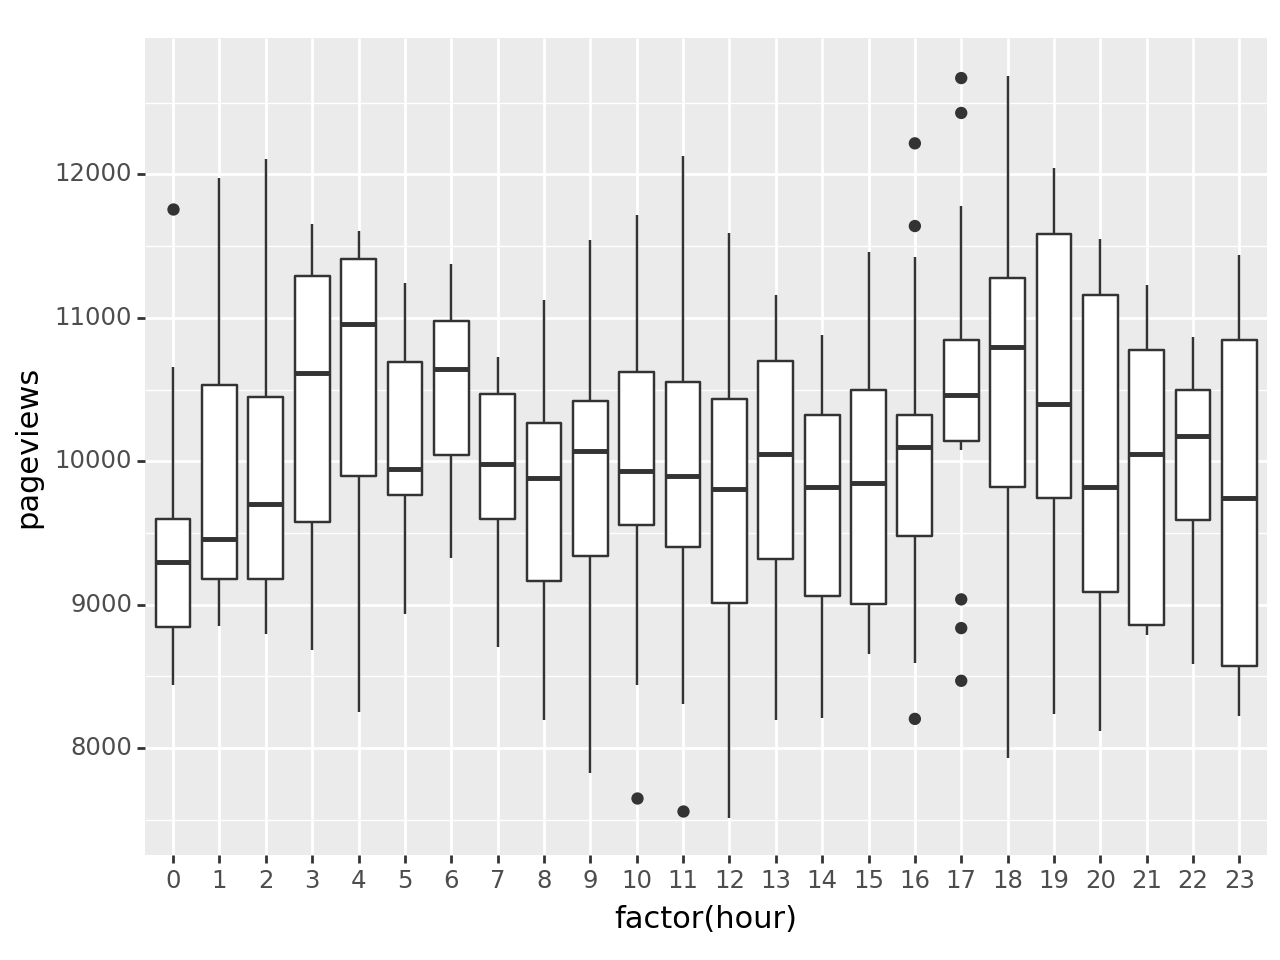

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(pageviews)
    + geom_boxplot(aes(x='factor(hour)', y='pageviews'))
)

But suppose we had 348 million rows in a datastore. This becomes impractical to fetch and compute the boxplot on the fly. Instead we can precompute the aggregate statistics and use that to plot the boxplot directly. 

Below we calculate the aggregate statistics in Pandas, but this could also be done in SQL/Pyspark on your datastore of choice. For simplicity, in this example, outliers haven't been removed before determining aggregate statistics.

In [13]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [14]:
precomputed_metrics = pageviews.groupby("hour").agg({'pageviews': [np.min, q25, np.median, q75, np.max]})
precomputed_metrics.columns = [col_name[1] for col_name in precomputed_metrics.columns]  
precomputed_metrics = precomputed_metrics.reset_index()
precomputed_metrics.head()

,hour,min,q25,median,q75,max
0,0,8437.500380,8842.109077,9297.046035,9600.362430,11762.446233
1,1,8852.123978,9177.938537,9457.821814,10530.072887,11974.437292
2,2,8793.076686,9176.462389,9704.885172,10446.315276,12105.406628
3,3,8683.606449,9574.722286,10615.670464,11290.246605,11651.443193
4,4,8252.974951,9898.998785,10959.909095,11409.657288,11603.711837


A simpler boxplot (without outlier points shown) can then be plotted:

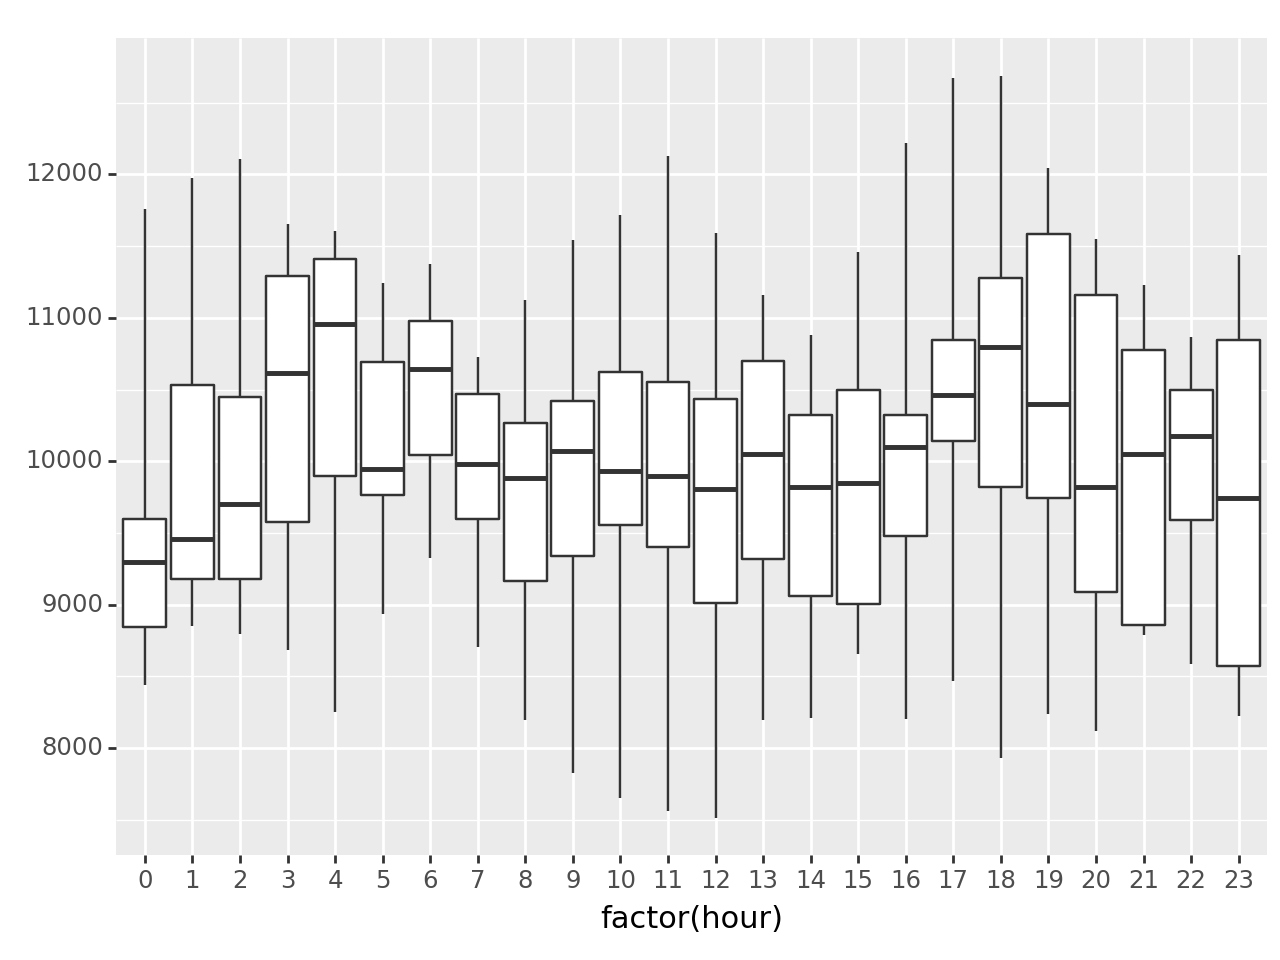

<Figure Size: (640 x 480)>

In [15]:
(
    ggplot(precomputed_metrics)
    + geom_boxplot(aes(x='factor(hour)', ymin='min', lower="q25", middle="median", upper="q75", ymax="max"), stat = "identity")
)